In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import scipy.stats as stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import pathlib
import re
import pandas as pd
import pickle
import csv
import statistics

In [2]:
import timeit

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

from sklearn.preprocessing import PolynomialFeatures

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import lightgbm
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer

import catboost as cb
from catboost import CatBoostClassifier

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
parent_path = str(pathlib.Path(os.path.normpath('C:\\Users\\lms-puvvalat\\Documents\\GitHub\\2022-svsm-afib-group1\\')))

rlist = []
records = os.path.normpath(parent_path + '/mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [4]:
performance_dict = {
    "Model name": [],
    "Avg Accuracy": [],
    "Std Accuracy": [],
    "Sensitivity": [],
    "Specificity": [],
    "Precision": [],
    "F1 score": [],
    "Run time": [],
    "TPS": []
}

moving_accuracy = {}

In [60]:
def score_reporter(initial_results):
    initial_columns = initial_results.axes[0].tolist()
    results = initial_results.dropna()
    changed_columns = results.axes[0].tolist()
    
    dropped_cols = list(set(initial_columns).difference(changed_columns))
    
    print(dropped_cols)

    acc_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_accuracy'
        if col_name not in dropped_cols:
            acc_scores.append(results[col_name])

    spec_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_specificity'
        if col_name not in dropped_cols:
            spec_scores.append(results[col_name])

    sens_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_sensitivity'
        if col_name not in dropped_cols:
            sens_scores.append(results[col_name])


    prec_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_precision'
        if col_name not in dropped_cols:
            prec_scores.append(results[col_name])

    f1_scores = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_f1_score'
        if col_name not in dropped_cols:
            f1_scores.append(results[col_name])
        
    elapsed_times = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_elapsed'
        if col_name not in dropped_cols:
            elapsed_times.append(results[col_name])

    eps_times = []
    for x in range(len(rlist)):
        col_name = 'split'+str(x)+'_test_eps'
        if col_name not in dropped_cols:
            eps_times.append(results[col_name])

    print('---Run time of each fold: \n {}'.format(elapsed_times))
    print("Avg run time: {}".format(np.mean(elapsed_times)))
    print('---Run time per subset of each fold is: \n {}'.format(eps_times))
    print("Avg run time per subset: {}".format(np.mean(eps_times)))
    print()
    print('Accuracy of each fold: \n {}'.format(acc_scores))
    print("Avg accuracy: {}".format(np.mean(acc_scores)))
    print('Std of accuracy : \n{}'.format(np.std(acc_scores)))
    print()
    print('Specificity of each fold: \n {}'.format(spec_scores))
    print("Avg specificity: {}".format(np.mean(spec_scores)))
    print('Std of specificity: \n{}'.format(np.std(spec_scores)))
    print()
    print('Sensitivity of each fold: \n {}'.format(sens_scores))
    print("Avg sensitivity: {}".format(np.mean(sens_scores)))
    print('Std of sensitivity: \n{}'.format(np.std(sens_scores)))
    print()
    print('Precision of each fold: \n {}'.format(prec_scores))
    print("Avg precision: {}".format(np.mean(prec_scores)))
    print('Std of precision : \n{}'.format(np.std(prec_scores)))
    print()
    print('F1-scores of each fold: \n {}'.format(f1_scores))
    print("Avg F1-scores: {}".format(np.mean(f1_scores)))
    print('Std of F1-scores : \n{}'.format(np.std(f1_scores)))

In [13]:
def scorer(clf, X, y):
    global moving_acc

    start_time = timeit.default_timer()
    y_pred = clf.predict(X)
    elapsed = timeit.default_timer() - start_time

    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(y_pred):
        total_seen+=1
        if pred==y.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)
    moving_acc.append(subject_acc)

    fold_size = len(X)

    cm = confusion_matrix(y, y_pred)

    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])
    f1_score = (2*precision*sensitivity)/(precision+sensitivity)

    return {'sensitivity': sensitivity, 'specificity': specificity,
            'precision': precision, 'f1_score': f1_score,
            'accuracy': accuracy_score(y, y_pred), 
            'elapsed': elapsed, 'eps': elapsed/fold_size}

In [7]:
feature_dfs = {}
for record in tqdm(rlist):
    feature_dfs[record] = pd.read_csv(os.path.normpath(parent_path + '/mit-bih-time-features/'+record+'.csv'), index_col=0, dtype={'subjectID': str})

combined_features = pd.concat([feature_dfs[key][1:] for key in feature_dfs])

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.91it/s]


In [8]:
X = combined_features[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'rmssd', 'iqr', 'mad', 'cov']]
y = combined_features['mappedLabel'].map({"Non-Afib": 0, "Afib": 1})
groups = combined_features['subjectID'].astype('int64')

logo = LeaveOneGroupOut()
splits = list(logo.split(X, y, groups=groups))

random search started
Fitting 23 folds for each of 10 candidates, totalling 230 fits


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   7.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   7.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   8.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   8.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   8.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   8.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   8.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.1s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   8.9s
[CV] END ......................max_depth=8, n_estimators=100; total time=   8.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   8.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   8.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   9.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=8, n_estimators=100; total time=   8.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.3s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.9s
[CV] END .....................max_depth=13, n_estimators=150; total time=  20.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  21.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=13, n_estimators=150; total time=  20.3s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  43.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  41.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  43.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  42.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  42.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  42.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  41.3s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  43.3s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  42.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  42.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  42.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  43.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  41.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  42.7s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  41.4s
[CV] END .....................max_depth=10, n_estimators=400; total time=  42.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  43.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  42.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  41.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  43.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  42.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  43.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=10, n_estimators=400; total time=  42.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  52.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  50.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  52.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  51.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  51.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  51.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  49.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  52.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  52.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  54.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  51.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  52.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  51.0s
[CV] END .....................max_depth=11, n_estimators=450; total time=  51.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  52.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  51.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  50.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  52.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  51.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  53.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=11, n_estimators=450; total time=  51.3s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  44.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  44.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  43.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  44.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  44.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  44.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.1s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  44.2s
[CV] END .....................max_depth=15, n_estimators=300; total time=  44.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  46.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  43.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  44.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  45.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=15, n_estimators=300; total time=  44.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  14.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  14.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.9s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.6s
[CV] END ......................max_depth=5, n_estimators=250; total time=  13.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  14.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  14.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=250; total time=  13.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  38.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  38.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  36.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  38.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.3s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  38.3s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.8s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  36.8s
[CV] END .....................max_depth=12, n_estimators=300; total time=  37.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  38.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  36.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  38.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.3s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  38.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=300; total time=  37.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=   9.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=   9.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=   9.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=   9.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=   9.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.0s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=   9.8s
[CV] END ......................max_depth=9, n_estimators=100; total time=   9.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=   9.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=   9.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=  10.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=9, n_estimators=100; total time=   9.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.5s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.3s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.4s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.6s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.1s
[CV] END ......................max_depth=5, n_estimators=450; total time=  24.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.3s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END ......................max_depth=5, n_estimators=450; total time=  24.2s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  13.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  12.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  13.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  12.8s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  12.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  13.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  13.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  12.9s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  12.6s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  13.0s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  12.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  13.1s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END .....................max_depth=12, n_estimators=100; total time=  12.7s


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


random search completed
[0.08114427 0.04406314 0.0260069  0.00745638 0.00834098 0.09141868
 0.03682363 0.0230824  0.02422542 0.0187797  0.01887748 0.07548366
 0.5442974 ]


OSError: Cannot save file into a non-existent directory: '\results'

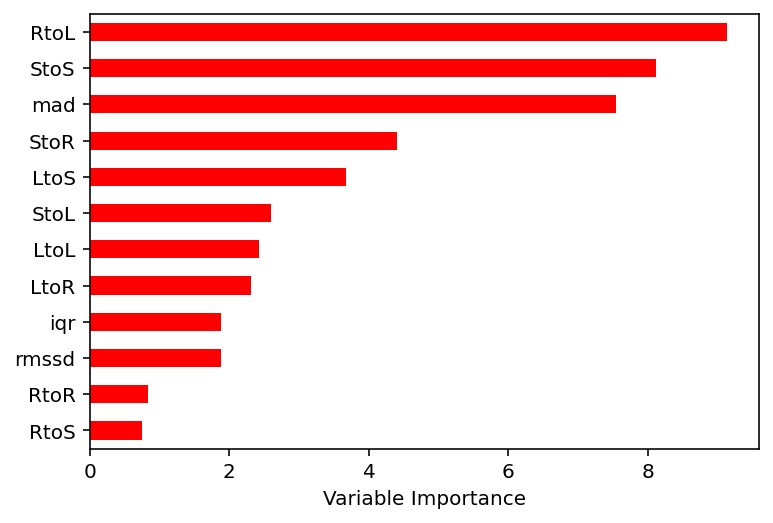

In [14]:
# XGBoost
moving_accuracy['xgboost'] = []
params = {
    "max_depth": list(range(1, 16)),
    "n_estimators": np.linspace(100, 500, 9).astype(int)
}

moving_acc = []

print("random search started")
randomsearch = RandomizedSearchCV(XGBClassifier(learning_rate = 0.1, use_label_encoder=False, verbose=None, eval_metric='logloss'), 
                                    param_distributions=params, refit='accuracy', scoring=scorer, verbose=2, cv=splits)
randomsearch.fit(X, y)
print("random search completed")

moving_accuracy['xgboost'] = moving_acc[(randomsearch.best_index_)*23:(randomsearch.best_index_*23)+23]

print(randomsearch.best_estimator_.feature_importances_)
Importance = pd.DataFrame({'Importance':(randomsearch.best_estimator_.feature_importances_*100)[0:12]}, 
                      index = (X.columns)[0:12])
Importance.sort_values(by = 'Importance', 
                   axis = 0, 
                   ascending = True).plot(kind = 'barh', 
                                          color = 'r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

results = pd.DataFrame(randomsearch.cv_results_)
results.to_csv(os.path.normpath(parent_path + '/models/subsets/results/xgboost_results.csv'))
print(results)

score_reporter(results.iloc[randomsearch.best_index_])

print(randomsearch.best_params_)

In [64]:
#os.mkdir(os.path.normpath(parent_path + '/models/subsets/results/'))
#results.to_csv(os.path.normpath(parent_path + '/models/subsets/results/xgboost_results.csv'))

#score_reporter(results.iloc[randomsearch.best_index_])

['mean_test_sensitivity', 'split14_test_f1_score', 'std_test_sensitivity', 'mean_test_f1_score', 'split14_test_sensitivity', 'split13_test_f1_score', 'std_test_f1_score', 'split13_test_sensitivity']
---Run time of each fold: 
 [0.008780300006037578, 0.011756100007914938, 0.008469399996101856, 0.009215900005074218, 0.00942070000746753, 0.01414410000143107, 0.00912380000227131, 0.008194999987608753, 0.010061400011181831, 0.006699400008074008, 0.007174700003815815, 0.006964500003959984, 0.011026699998183176, 0.008218499991926365, 0.012259999988600612, 0.010821000003488734, 0.00831330000073649, 0.008963000000221655, 0.011791299999458715, 0.00891099999716971, 0.011537500002305023, 0.008675899996887892, 0.011318800010485575]
Avg run time: 0.00964531739262621
---Run time per subset of each fold is: 
 [1.2003144232450552e-06, 1.1412581310469797e-06, 1.277435896847942e-06, 1.2936412135140676e-06, 1.1833563632040612e-06, 1.3765547446648243e-06, 1.022618247284388e-06, 1.341463412605787e-06, 1.212

random search started
Fitting 23 folds for each of 10 candidates, totalling 230 fits
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s
[CV] END ...............

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=400; total time=   0.6s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ..

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=8, n_estimators=300; total time=   0.8s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=8, n_estimators=300; total time=   0.8s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ......................max_depth=8, n_estimators=300; total time=   0.8s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ......................max_depth=8, n_estimators=300; total time=   0.8s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_le

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=3, n_estimators=150; total time=   0.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=3, n_estimators=150; total time=   0.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END ......................max_depth=3, n_estimators=150; total time=   0.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END ......................max_depth=3, n_estimators=150; total time=   0.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END ......................max_depth=3, n_estimators=150; total time=   0.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END ......................max_depth=3, n_estimators=150; total time=   0.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=2, n_estimators=100; total time=   0.2s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=2, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=3, n_estimators=350; total time=   0.6s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END ......................max_depth=3, n_estimators=350; total time=   0.7s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END ......................max_depth=3, n_estimators=350; total time=   0.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=5, n_estimators=450; total time=   1.2s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=5, n_estimators=450; total time=   1.2s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=8, n_estimators=450; total time=   1.1s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=8, n_estimators=450; total time=   1.2s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ......................max_depth=8, n_estimators=450; total time=   1.1s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ......................max_depth=8, n_estimators=450; total time=   1.2s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_le

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .....................max_depth=10, n_estimators=150; total time=   0.5s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .....................max_depth=10, n_estimators=150; total time=   0.5s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END .....................max_depth=10, n_estimators=150; total time=   0.5s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END .....................max_depth=10, n_estimators=150; total time=   0.4s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_le

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=2, n_estimators=500; total time=   0.9s


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ......................max_depth=2, n_estimators=500; total time=   0.9s
[CV] END ......................max_depth=2, n_estimators=500; total time=   0.8s
[CV] END ......................max_depth=2, n_estimators=500; total time=   0.9s
[CV] END ......................max_depth=2, n_estimators=500; total time=   0.8s
[CV] END ......................max_depth=2, n_estimators=500; total time=   0.9s
[CV] END ......................max_depth=2, n_estimators=500; total time=   0.8s
[CV] END ......................max_depth=2, n_estimators=500; total time=   0.9s
[CV] END ......................max_depth=2, n_estimators=500; total time=   0.8s
[CV] END ......................max_depth=2, n_estimators=500; total time=   0.9s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ..

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .....................max_depth=13, n_estimators=250; total time=   0.7s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .....................max_depth=13, n_estimators=250; total time=   0.7s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END .....................max_depth=13, n_estimators=250; total time=   0.7s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END .....................max_depth=13, n_estimators=250; total time=   0.7s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_le

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


random search completed
[1333 1092 1503  665  500  823 1412  916 1337  931  864  813 1311]
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.567081      0.035030         0.084941        0.018273   
1       0.802653      0.050112         0.089876        0.021122   
2       0.375903      0.027707         0.082406        0.016935   
3       0.262626      0.028586         0.079689        0.018197   
4       0.711324      0.031302         0.090885        0.019460   
5       1.180149      0.029832         0.105945        0.019701   
6       1.168868      0.043628         0.105543        0.019350   
7       0.491324      0.024927         0.087159        0.019194   
8       0.869154      0.037189         0.095765        0.016802   
9       0.723357      0.036847         0.091689        0.018021   

  param_n_estimators param_max_depth                                  params  \
0                400               1   {'n_estimators': 400, 'max_depth': 1}   
1          

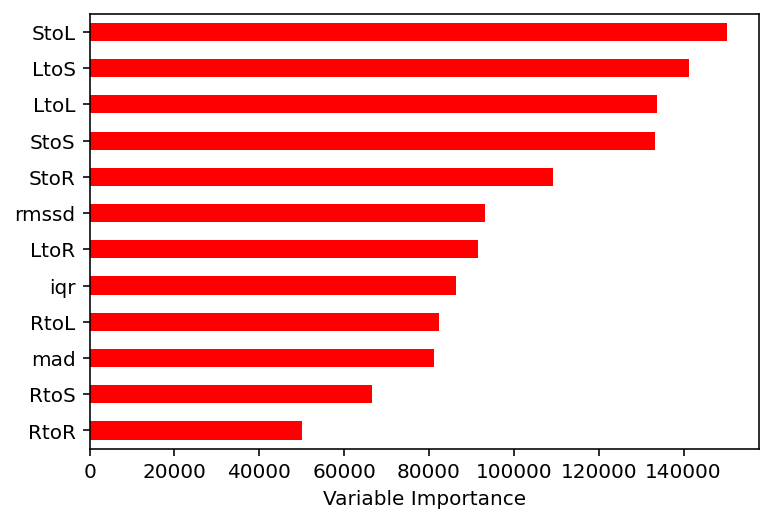

In [72]:
# LightGBM
moving_accuracy['lightgbm'] = []
params = {
    "max_depth": list(range(1, 16)),
    "n_estimators": np.linspace(100, 500, 9).astype(int)
}

moving_acc = []

print("random search started")
randomsearch = RandomizedSearchCV(lightgbm.LGBMClassifier(learning_rate=0.09,verbose=0,random_state=2, force_col_wise=True), 
                                    param_distributions=params, refit='accuracy', scoring=scorer, verbose=2, cv=splits)
randomsearch.fit(X, y)
print("random search completed")

moving_accuracy['lightgbm'] = moving_acc[(randomsearch.best_index_)*23:(randomsearch.best_index_*23)+23]

print(randomsearch.best_estimator_.feature_importances_)
Importance = pd.DataFrame({'Importance':(randomsearch.best_estimator_.feature_importances_*100)[0:12]}, 
                      index = (X.columns)[0:12])
Importance.sort_values(by = 'Importance', 
                   axis = 0, 
                   ascending = True).plot(kind = 'barh', 
                                          color = 'r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

results = pd.DataFrame(randomsearch.cv_results_)
results.to_csv(os.path.normpath(parent_path + '/models/subsets/results/lightgbm_results.csv'))
print(results)

score_reporter(results.iloc[randomsearch.best_index_])

print(randomsearch.best_params_)

random search started
Fitting 23 folds for each of 10 candidates, totalling 230 fits
0:	learn: 0.5073386	total: 170ms	remaining: 59.4s
1:	learn: 0.3995381	total: 207ms	remaining: 36s
2:	learn: 0.3238315	total: 242ms	remaining: 28s
3:	learn: 0.2765280	total: 276ms	remaining: 23.9s
4:	learn: 0.2441025	total: 309ms	remaining: 21.3s
5:	learn: 0.2193993	total: 343ms	remaining: 19.6s
6:	learn: 0.2016398	total: 375ms	remaining: 18.4s
7:	learn: 0.1871260	total: 409ms	remaining: 17.5s
8:	learn: 0.1746150	total: 451ms	remaining: 17.1s
9:	learn: 0.1650252	total: 483ms	remaining: 16.4s
10:	learn: 0.1577145	total: 517ms	remaining: 15.9s
11:	learn: 0.1516930	total: 554ms	remaining: 15.6s
12:	learn: 0.1466793	total: 594ms	remaining: 15.4s
13:	learn: 0.1427795	total: 630ms	remaining: 15.1s
14:	learn: 0.1393996	total: 665ms	remaining: 14.9s
15:	learn: 0.1366342	total: 701ms	remaining: 14.6s
16:	learn: 0.1339226	total: 738ms	remaining: 14.4s
17:	learn: 0.1311121	total: 773ms	remaining: 14.3s
18:	learn: 

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


0:	learn: 0.4997484	total: 43.4ms	remaining: 15.1s
1:	learn: 0.3792893	total: 81.2ms	remaining: 14.1s
2:	learn: 0.3054563	total: 117ms	remaining: 13.5s
3:	learn: 0.2604377	total: 153ms	remaining: 13.2s
4:	learn: 0.2276852	total: 187ms	remaining: 12.9s
5:	learn: 0.2018559	total: 221ms	remaining: 12.7s
6:	learn: 0.1836080	total: 255ms	remaining: 12.5s
7:	learn: 0.1706289	total: 289ms	remaining: 12.4s
8:	learn: 0.1607380	total: 323ms	remaining: 12.3s
9:	learn: 0.1530814	total: 357ms	remaining: 12.1s
10:	learn: 0.1465848	total: 391ms	remaining: 12.1s
11:	learn: 0.1414721	total: 425ms	remaining: 12s
12:	learn: 0.1375933	total: 459ms	remaining: 11.9s
13:	learn: 0.1337452	total: 494ms	remaining: 11.9s
14:	learn: 0.1303409	total: 527ms	remaining: 11.8s
15:	learn: 0.1278963	total: 563ms	remaining: 11.7s
16:	learn: 0.1255030	total: 599ms	remaining: 11.7s
17:	learn: 0.1230014	total: 636ms	remaining: 11.7s
18:	learn: 0.1210612	total: 673ms	remaining: 11.7s
19:	learn: 0.1193597	total: 710ms	remaini

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .......................iterations=350, max_depth=10; total time=  13.3s
0:	learn: 0.5193760	total: 37.7ms	remaining: 13.2s
1:	learn: 0.4067298	total: 73.9ms	remaining: 12.9s
2:	learn: 0.3322801	total: 108ms	remaining: 12.5s
3:	learn: 0.2820728	total: 142ms	remaining: 12.3s
4:	learn: 0.2480291	total: 177ms	remaining: 12.2s
5:	learn: 0.2232825	total: 213ms	remaining: 12.2s
6:	learn: 0.2049648	total: 247ms	remaining: 12.1s
7:	learn: 0.1915700	total: 282ms	remaining: 12s
8:	learn: 0.1800029	total: 316ms	remaining: 12s
9:	learn: 0.1719551	total: 351ms	remaining: 11.9s
10:	learn: 0.1652369	total: 386ms	remaining: 11.9s
11:	learn: 0.1594871	total: 423ms	remaining: 11.9s
12:	learn: 0.1544321	total: 460ms	remaining: 11.9s
13:	learn: 0.1502167	total: 500ms	remaining: 12s
14:	learn: 0.1464388	total: 536ms	remaining: 12s
15:	learn: 0.1435817	total: 573ms	remaining: 12s
16:	learn: 0.1409629	total: 620ms	remaining: 12.1s
17:	learn: 0.1387947	total: 663ms	remaining: 12.2s
18:	learn: 0.136883

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


0:	learn: 0.5906579	total: 13.5ms	remaining: 5.4s
1:	learn: 0.5072605	total: 20.1ms	remaining: 4s
2:	learn: 0.4507399	total: 26.7ms	remaining: 3.53s
3:	learn: 0.4108306	total: 32.7ms	remaining: 3.24s
4:	learn: 0.3794513	total: 38.7ms	remaining: 3.06s
5:	learn: 0.3518946	total: 44.8ms	remaining: 2.94s
6:	learn: 0.3290196	total: 50.9ms	remaining: 2.86s
7:	learn: 0.3080872	total: 56.6ms	remaining: 2.77s
8:	learn: 0.2919860	total: 62.4ms	remaining: 2.71s
9:	learn: 0.2785395	total: 67.9ms	remaining: 2.65s
10:	learn: 0.2682180	total: 73.4ms	remaining: 2.6s
11:	learn: 0.2574787	total: 79.3ms	remaining: 2.56s
12:	learn: 0.2478626	total: 85.4ms	remaining: 2.54s
13:	learn: 0.2411320	total: 91.2ms	remaining: 2.51s
14:	learn: 0.2310140	total: 97.2ms	remaining: 2.49s
15:	learn: 0.2246241	total: 103ms	remaining: 2.48s
16:	learn: 0.2200443	total: 109ms	remaining: 2.46s
17:	learn: 0.2155254	total: 115ms	remaining: 2.44s
18:	learn: 0.2118771	total: 121ms	remaining: 2.42s
19:	learn: 0.2087402	total: 127

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ........................iterations=400, max_depth=1; total time=   2.4s
0:	learn: 0.6009724	total: 17.5ms	remaining: 6.99s
1:	learn: 0.5222766	total: 24.5ms	remaining: 4.88s
2:	learn: 0.4742973	total: 30.6ms	remaining: 4.04s
3:	learn: 0.4390561	total: 36.8ms	remaining: 3.65s
4:	learn: 0.4082834	total: 42.9ms	remaining: 3.39s
5:	learn: 0.3828522	total: 48.7ms	remaining: 3.19s
6:	learn: 0.3606527	total: 54.8ms	remaining: 3.07s
7:	learn: 0.3446744	total: 59.8ms	remaining: 2.93s
8:	learn: 0.3276435	total: 65.7ms	remaining: 2.85s
9:	learn: 0.3159742	total: 71.3ms	remaining: 2.78s
10:	learn: 0.3050954	total: 76.8ms	remaining: 2.72s
11:	learn: 0.2959968	total: 82.4ms	remaining: 2.67s
12:	learn: 0.2850847	total: 88.4ms	remaining: 2.63s
13:	learn: 0.2746550	total: 94.1ms	remaining: 2.6s
14:	learn: 0.2675757	total: 99.8ms	remaining: 2.56s
15:	learn: 0.2599287	total: 106ms	remaining: 2.54s
16:	learn: 0.2554740	total: 112ms	remaining: 2.53s
17:	learn: 0.2511414	total: 118ms	remaining: 2.5

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .......................iterations=400, max_depth=13; total time= 1.4min
0:	learn: 0.4979766	total: 202ms	remaining: 1m 20s
1:	learn: 0.3860218	total: 432ms	remaining: 1m 26s
2:	learn: 0.3041908	total: 622ms	remaining: 1m 22s
3:	learn: 0.2531237	total: 839ms	remaining: 1m 23s
4:	learn: 0.2175752	total: 1.06s	remaining: 1m 23s
5:	learn: 0.1924320	total: 1.27s	remaining: 1m 23s
6:	learn: 0.1746165	total: 1.5s	remaining: 1m 24s
7:	learn: 0.1612449	total: 1.69s	remaining: 1m 22s
8:	learn: 0.1498272	total: 1.9s	remaining: 1m 22s
9:	learn: 0.1413674	total: 2.12s	remaining: 1m 22s
10:	learn: 0.1350381	total: 2.33s	remaining: 1m 22s
11:	learn: 0.1297130	total: 2.56s	remaining: 1m 22s
12:	learn: 0.1252523	total: 2.75s	remaining: 1m 21s
13:	learn: 0.1216218	total: 2.96s	remaining: 1m 21s
14:	learn: 0.1184941	total: 3.17s	remaining: 1m 21s
15:	learn: 0.1153285	total: 3.4s	remaining: 1m 21s
16:	learn: 0.1129677	total: 3.59s	remaining: 1m 20s
17:	learn: 0.1106570	total: 3.8s	remaining: 1m 2

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .......................iterations=400, max_depth=13; total time= 1.5min
0:	learn: 0.5165738	total: 200ms	remaining: 1m 19s
1:	learn: 0.3998461	total: 416ms	remaining: 1m 22s
2:	learn: 0.3233783	total: 667ms	remaining: 1m 28s
3:	learn: 0.2728737	total: 878ms	remaining: 1m 26s
4:	learn: 0.2371260	total: 1.1s	remaining: 1m 26s
5:	learn: 0.2124122	total: 1.32s	remaining: 1m 26s
6:	learn: 0.1931250	total: 1.54s	remaining: 1m 26s
7:	learn: 0.1782660	total: 1.75s	remaining: 1m 25s
8:	learn: 0.1679320	total: 1.94s	remaining: 1m 24s
9:	learn: 0.1584790	total: 2.13s	remaining: 1m 23s
10:	learn: 0.1516770	total: 2.34s	remaining: 1m 22s
11:	learn: 0.1464715	total: 2.57s	remaining: 1m 23s
12:	learn: 0.1416959	total: 2.75s	remaining: 1m 21s
13:	learn: 0.1381200	total: 2.96s	remaining: 1m 21s
14:	learn: 0.1348019	total: 3.17s	remaining: 1m 21s
15:	learn: 0.1314525	total: 3.38s	remaining: 1m 21s
16:	learn: 0.1287187	total: 3.61s	remaining: 1m 21s
17:	learn: 0.1261316	total: 3.8s	remaining: 1m

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


0:	learn: 0.5057216	total: 30.9ms	remaining: 12.3s
1:	learn: 0.4023448	total: 43.8ms	remaining: 8.72s
2:	learn: 0.3274012	total: 57ms	remaining: 7.55s
3:	learn: 0.2747733	total: 69.9ms	remaining: 6.92s
4:	learn: 0.2392082	total: 82.9ms	remaining: 6.54s
5:	learn: 0.2169713	total: 95.5ms	remaining: 6.27s
6:	learn: 0.1983410	total: 109ms	remaining: 6.1s
7:	learn: 0.1839961	total: 121ms	remaining: 5.93s
8:	learn: 0.1732134	total: 134ms	remaining: 5.81s
9:	learn: 0.1659309	total: 147ms	remaining: 5.73s
10:	learn: 0.1586895	total: 159ms	remaining: 5.63s
11:	learn: 0.1531623	total: 172ms	remaining: 5.55s
12:	learn: 0.1481819	total: 184ms	remaining: 5.47s
13:	learn: 0.1441256	total: 196ms	remaining: 5.41s
14:	learn: 0.1407594	total: 209ms	remaining: 5.35s
15:	learn: 0.1384048	total: 221ms	remaining: 5.31s
16:	learn: 0.1362281	total: 233ms	remaining: 5.26s
17:	learn: 0.1342563	total: 246ms	remaining: 5.22s
18:	learn: 0.1326047	total: 258ms	remaining: 5.18s
19:	learn: 0.1308859	total: 272ms	rema

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


0:	learn: 0.5268320	total: 25.2ms	remaining: 10.1s
1:	learn: 0.4195594	total: 37.6ms	remaining: 7.49s
2:	learn: 0.3483983	total: 50ms	remaining: 6.62s
3:	learn: 0.2990940	total: 62.1ms	remaining: 6.15s
4:	learn: 0.2654807	total: 74.5ms	remaining: 5.89s
5:	learn: 0.2420134	total: 86.8ms	remaining: 5.7s
6:	learn: 0.2227488	total: 99.6ms	remaining: 5.59s
7:	learn: 0.2086204	total: 113ms	remaining: 5.53s
8:	learn: 0.1974958	total: 126ms	remaining: 5.47s
9:	learn: 0.1887178	total: 139ms	remaining: 5.43s
10:	learn: 0.1819807	total: 152ms	remaining: 5.39s
11:	learn: 0.1758305	total: 165ms	remaining: 5.34s
12:	learn: 0.1705558	total: 178ms	remaining: 5.29s
13:	learn: 0.1668046	total: 190ms	remaining: 5.24s
14:	learn: 0.1634153	total: 203ms	remaining: 5.21s
15:	learn: 0.1599986	total: 216ms	remaining: 5.18s
16:	learn: 0.1575767	total: 228ms	remaining: 5.13s
17:	learn: 0.1553761	total: 241ms	remaining: 5.1s
18:	learn: 0.1531167	total: 254ms	remaining: 5.09s
19:	learn: 0.1510342	total: 266ms	rema

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


0:	learn: 0.5550125	total: 12.1ms	remaining: 6.02s
1:	learn: 0.4663654	total: 19.2ms	remaining: 4.77s
2:	learn: 0.4015503	total: 25.8ms	remaining: 4.28s
3:	learn: 0.3508716	total: 32.6ms	remaining: 4.04s
4:	learn: 0.3127434	total: 39.6ms	remaining: 3.92s
5:	learn: 0.2870324	total: 46.3ms	remaining: 3.81s
6:	learn: 0.2625858	total: 53.2ms	remaining: 3.75s
7:	learn: 0.2470140	total: 59.9ms	remaining: 3.69s
8:	learn: 0.2343006	total: 66.7ms	remaining: 3.64s
9:	learn: 0.2231581	total: 73.8ms	remaining: 3.62s
10:	learn: 0.2143623	total: 81.3ms	remaining: 3.61s
11:	learn: 0.2073338	total: 88.1ms	remaining: 3.58s
12:	learn: 0.2012892	total: 95.1ms	remaining: 3.56s
13:	learn: 0.1964032	total: 102ms	remaining: 3.53s
14:	learn: 0.1906200	total: 108ms	remaining: 3.51s
15:	learn: 0.1877998	total: 115ms	remaining: 3.47s
16:	learn: 0.1832893	total: 121ms	remaining: 3.45s
17:	learn: 0.1809565	total: 128ms	remaining: 3.44s
18:	learn: 0.1774588	total: 135ms	remaining: 3.43s
19:	learn: 0.1756802	total: 

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


3:	learn: 0.3807134	total: 45.7ms	remaining: 5.66s
4:	learn: 0.3436134	total: 52.4ms	remaining: 5.19s
5:	learn: 0.3172970	total: 59.3ms	remaining: 4.88s
6:	learn: 0.2981576	total: 66ms	remaining: 4.65s
7:	learn: 0.2834685	total: 72.7ms	remaining: 4.47s
8:	learn: 0.2699107	total: 79.7ms	remaining: 4.35s
9:	learn: 0.2574786	total: 86.7ms	remaining: 4.25s
10:	learn: 0.2467649	total: 93.3ms	remaining: 4.15s
11:	learn: 0.2382644	total: 99.8ms	remaining: 4.06s
12:	learn: 0.2302196	total: 107ms	remaining: 4s
13:	learn: 0.2248059	total: 114ms	remaining: 3.94s
14:	learn: 0.2210890	total: 120ms	remaining: 3.87s
15:	learn: 0.2180717	total: 126ms	remaining: 3.81s
16:	learn: 0.2136897	total: 133ms	remaining: 3.78s
17:	learn: 0.2109035	total: 140ms	remaining: 3.74s
18:	learn: 0.2086014	total: 146ms	remaining: 3.71s
19:	learn: 0.2052938	total: 153ms	remaining: 3.67s
20:	learn: 0.2036007	total: 160ms	remaining: 3.65s
21:	learn: 0.2004479	total: 166ms	remaining: 3.62s
22:	learn: 0.1989266	total: 173ms	

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ........................iterations=300, max_depth=1; total time=   1.9s
0:	learn: 0.5906579	total: 8.95ms	remaining: 2.68s
1:	learn: 0.5072605	total: 15.4ms	remaining: 2.29s
2:	learn: 0.4507399	total: 21.4ms	remaining: 2.12s
3:	learn: 0.4108306	total: 27.2ms	remaining: 2.01s
4:	learn: 0.3794513	total: 33ms	remaining: 1.95s
5:	learn: 0.3518946	total: 38.8ms	remaining: 1.9s
6:	learn: 0.3290196	total: 44.5ms	remaining: 1.86s
7:	learn: 0.3080872	total: 50.2ms	remaining: 1.83s
8:	learn: 0.2919860	total: 56.1ms	remaining: 1.81s
9:	learn: 0.2785395	total: 61.5ms	remaining: 1.78s
10:	learn: 0.2682180	total: 67.1ms	remaining: 1.76s
11:	learn: 0.2574787	total: 72.9ms	remaining: 1.75s
12:	learn: 0.2478626	total: 78.8ms	remaining: 1.74s
13:	learn: 0.2411320	total: 84.7ms	remaining: 1.73s
14:	learn: 0.2310140	total: 90.9ms	remaining: 1.73s
15:	learn: 0.2246241	total: 96.9ms	remaining: 1.72s
16:	learn: 0.2200443	total: 103ms	remaining: 1.71s
17:	learn: 0.2155254	total: 108ms	remaining: 1.7s

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ........................iterations=300, max_depth=1; total time=   1.8s
0:	learn: 0.6009724	total: 10ms	remaining: 3s
1:	learn: 0.5222766	total: 16.5ms	remaining: 2.46s
2:	learn: 0.4742973	total: 22.6ms	remaining: 2.23s
3:	learn: 0.4390561	total: 29.3ms	remaining: 2.17s
4:	learn: 0.4082834	total: 35.5ms	remaining: 2.09s
5:	learn: 0.3828522	total: 41.2ms	remaining: 2.02s
6:	learn: 0.3606527	total: 47.4ms	remaining: 1.98s
7:	learn: 0.3446744	total: 52.8ms	remaining: 1.93s
8:	learn: 0.3276435	total: 59ms	remaining: 1.91s
9:	learn: 0.3159742	total: 65ms	remaining: 1.88s
10:	learn: 0.3050954	total: 70.6ms	remaining: 1.86s
11:	learn: 0.2959968	total: 76.4ms	remaining: 1.83s
12:	learn: 0.2850847	total: 82.3ms	remaining: 1.82s
13:	learn: 0.2746550	total: 88.3ms	remaining: 1.8s
14:	learn: 0.2675757	total: 94.1ms	remaining: 1.79s
15:	learn: 0.2599287	total: 100ms	remaining: 1.77s
16:	learn: 0.2554740	total: 106ms	remaining: 1.76s
17:	learn: 0.2511414	total: 112ms	remaining: 1.76s
18:	le

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .......................iterations=300, max_depth=13; total time= 1.1min
0:	learn: 0.4979766	total: 194ms	remaining: 57.9s
1:	learn: 0.3860218	total: 403ms	remaining: 60s
2:	learn: 0.3041908	total: 638ms	remaining: 1m 3s
3:	learn: 0.2531237	total: 848ms	remaining: 1m 2s
4:	learn: 0.2175752	total: 1.06s	remaining: 1m 2s
5:	learn: 0.1924320	total: 1.27s	remaining: 1m 2s
6:	learn: 0.1746165	total: 1.48s	remaining: 1m 1s
7:	learn: 0.1612449	total: 1.71s	remaining: 1m 2s
8:	learn: 0.1498272	total: 1.9s	remaining: 1m 1s
9:	learn: 0.1413674	total: 2.11s	remaining: 1m 1s
10:	learn: 0.1350381	total: 2.32s	remaining: 1m 1s
11:	learn: 0.1297130	total: 2.54s	remaining: 1m
12:	learn: 0.1252523	total: 2.77s	remaining: 1m 1s
13:	learn: 0.1216218	total: 2.97s	remaining: 1m
14:	learn: 0.1184941	total: 3.2s	remaining: 1m
15:	learn: 0.1153285	total: 3.41s	remaining: 1m
16:	learn: 0.1129677	total: 3.64s	remaining: 1m
17:	learn: 0.1106570	total: 3.84s	remaining: 1m
18:	learn: 0.1088626	total: 4.03s

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END .......................iterations=300, max_depth=13; total time= 1.1min
0:	learn: 0.5165738	total: 194ms	remaining: 58.1s
1:	learn: 0.3998461	total: 406ms	remaining: 1m
2:	learn: 0.3233783	total: 626ms	remaining: 1m 1s
3:	learn: 0.2728737	total: 836ms	remaining: 1m 1s
4:	learn: 0.2371260	total: 1.06s	remaining: 1m 2s
5:	learn: 0.2124122	total: 1.27s	remaining: 1m 2s
6:	learn: 0.1931250	total: 1.46s	remaining: 1m 1s
7:	learn: 0.1782660	total: 1.67s	remaining: 1m
8:	learn: 0.1679320	total: 1.88s	remaining: 1m
9:	learn: 0.1584790	total: 2.1s	remaining: 1m
10:	learn: 0.1516770	total: 2.3s	remaining: 1m
11:	learn: 0.1464715	total: 2.51s	remaining: 1m
12:	learn: 0.1416959	total: 2.72s	remaining: 1m
13:	learn: 0.1381200	total: 2.94s	remaining: 1m
14:	learn: 0.1348019	total: 3.14s	remaining: 59.6s
15:	learn: 0.1314525	total: 3.34s	remaining: 59.3s
16:	learn: 0.1287187	total: 3.57s	remaining: 59.4s
17:	learn: 0.1261316	total: 3.78s	remaining: 59.2s
18:	learn: 0.1238664	total: 4.02s	rem

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


0:	learn: 0.5046208	total: 26.8ms	remaining: 10.7s
1:	learn: 0.3897343	total: 41.9ms	remaining: 8.34s
2:	learn: 0.3192579	total: 56.6ms	remaining: 7.49s
3:	learn: 0.2702694	total: 71.6ms	remaining: 7.08s
4:	learn: 0.2361427	total: 86.8ms	remaining: 6.86s
5:	learn: 0.2111784	total: 101ms	remaining: 6.65s
6:	learn: 0.1938467	total: 116ms	remaining: 6.51s
7:	learn: 0.1810721	total: 130ms	remaining: 6.37s
8:	learn: 0.1709767	total: 146ms	remaining: 6.33s
9:	learn: 0.1624021	total: 161ms	remaining: 6.27s
10:	learn: 0.1555740	total: 178ms	remaining: 6.29s
11:	learn: 0.1499611	total: 193ms	remaining: 6.23s
12:	learn: 0.1452279	total: 207ms	remaining: 6.16s
13:	learn: 0.1411094	total: 222ms	remaining: 6.12s
14:	learn: 0.1372557	total: 237ms	remaining: 6.08s
15:	learn: 0.1348391	total: 252ms	remaining: 6.05s
16:	learn: 0.1328317	total: 267ms	remaining: 6.01s
17:	learn: 0.1309127	total: 283ms	remaining: 6s
18:	learn: 0.1288528	total: 298ms	remaining: 5.97s
19:	learn: 0.1273677	total: 313ms	remai

C:\Users\lms-puvvalat\AppData\Local\Temp\ipykernel_19240\1056965083.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])


[CV] END ........................iterations=400, max_depth=8; total time=   6.1s
0:	learn: 0.5213052	total: 21ms	remaining: 8.38s
1:	learn: 0.4058010	total: 35.9ms	remaining: 7.14s
2:	learn: 0.3399922	total: 50.8ms	remaining: 6.73s
3:	learn: 0.2923225	total: 65.6ms	remaining: 6.49s
4:	learn: 0.2587176	total: 80.7ms	remaining: 6.38s
5:	learn: 0.2348480	total: 97.4ms	remaining: 6.39s
6:	learn: 0.2162905	total: 113ms	remaining: 6.35s
7:	learn: 0.2019904	total: 128ms	remaining: 6.27s
8:	learn: 0.1899447	total: 143ms	remaining: 6.21s
9:	learn: 0.1816086	total: 159ms	remaining: 6.19s
10:	learn: 0.1745961	total: 174ms	remaining: 6.14s
11:	learn: 0.1686764	total: 189ms	remaining: 6.12s
12:	learn: 0.1642143	total: 204ms	remaining: 6.06s
13:	learn: 0.1597540	total: 218ms	remaining: 6.02s
14:	learn: 0.1567041	total: 233ms	remaining: 5.97s
15:	learn: 0.1534495	total: 248ms	remaining: 5.94s
16:	learn: 0.1512291	total: 262ms	remaining: 5.91s
17:	learn: 0.1486901	total: 277ms	remaining: 5.88s
18:	lea

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


10:	learn: 0.1739367	total: 173ms	remaining: 6.11s
11:	learn: 0.1681256	total: 189ms	remaining: 6.1s
12:	learn: 0.1639497	total: 204ms	remaining: 6.08s
13:	learn: 0.1598005	total: 219ms	remaining: 6.05s
14:	learn: 0.1557130	total: 236ms	remaining: 6.05s
15:	learn: 0.1529921	total: 251ms	remaining: 6.02s
16:	learn: 0.1499928	total: 266ms	remaining: 5.99s
17:	learn: 0.1473715	total: 282ms	remaining: 5.99s
18:	learn: 0.1450651	total: 298ms	remaining: 5.97s
19:	learn: 0.1434591	total: 313ms	remaining: 5.94s
20:	learn: 0.1413744	total: 329ms	remaining: 5.93s
21:	learn: 0.1397029	total: 344ms	remaining: 5.92s
22:	learn: 0.1382142	total: 360ms	remaining: 5.9s
23:	learn: 0.1368405	total: 375ms	remaining: 5.87s
24:	learn: 0.1356074	total: 390ms	remaining: 5.84s
25:	learn: 0.1344781	total: 405ms	remaining: 5.83s
26:	learn: 0.1336097	total: 420ms	remaining: 5.8s
27:	learn: 0.1327183	total: 435ms	remaining: 5.78s
28:	learn: 0.1316683	total: 450ms	remaining: 5.76s
29:	learn: 0.1309058	total: 465ms	

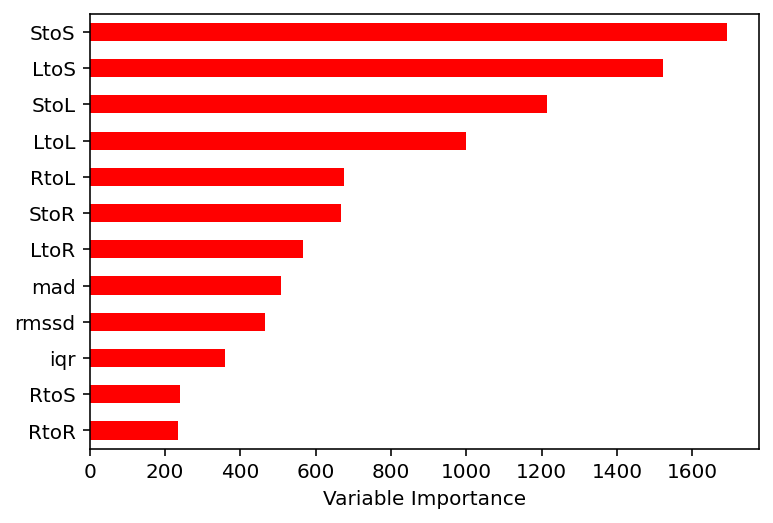

In [73]:
# CatBoost
moving_accuracy['catboost'] = []
params = {
    "max_depth": list(range(1, 16)),
    "iterations": np.linspace(100, 500, 9).astype(int)
}

moving_acc = []

print("random search started")
randomsearch = RandomizedSearchCV(CatBoostClassifier(learning_rate=0.1, loss_function='Logloss', verbose=None), 
                                    param_distributions=params, refit='accuracy', scoring=scorer, verbose=2, cv=splits)
randomsearch.fit(X, y)
print("random search completed")

moving_accuracy['catboost'] = moving_acc[(randomsearch.best_index_)*23:(randomsearch.best_index_*23)+23]

print(randomsearch.best_estimator_.feature_importances_)
Importance = pd.DataFrame({'Importance':(randomsearch.best_estimator_.feature_importances_*100)[0:12]}, 
                      index = (X.columns)[0:12])
Importance.sort_values(by = 'Importance', 
                   axis = 0, 
                   ascending = True).plot(kind = 'barh', 
                                          color = 'r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

results = pd.DataFrame(randomsearch.cv_results_)
results.to_csv(os.path.normpath(parent_path + '/models/subsets/results/catboost_results.csv'))
print(results)

score_reporter(results.iloc[randomsearch.best_index_])

print(randomsearch.best_params_)

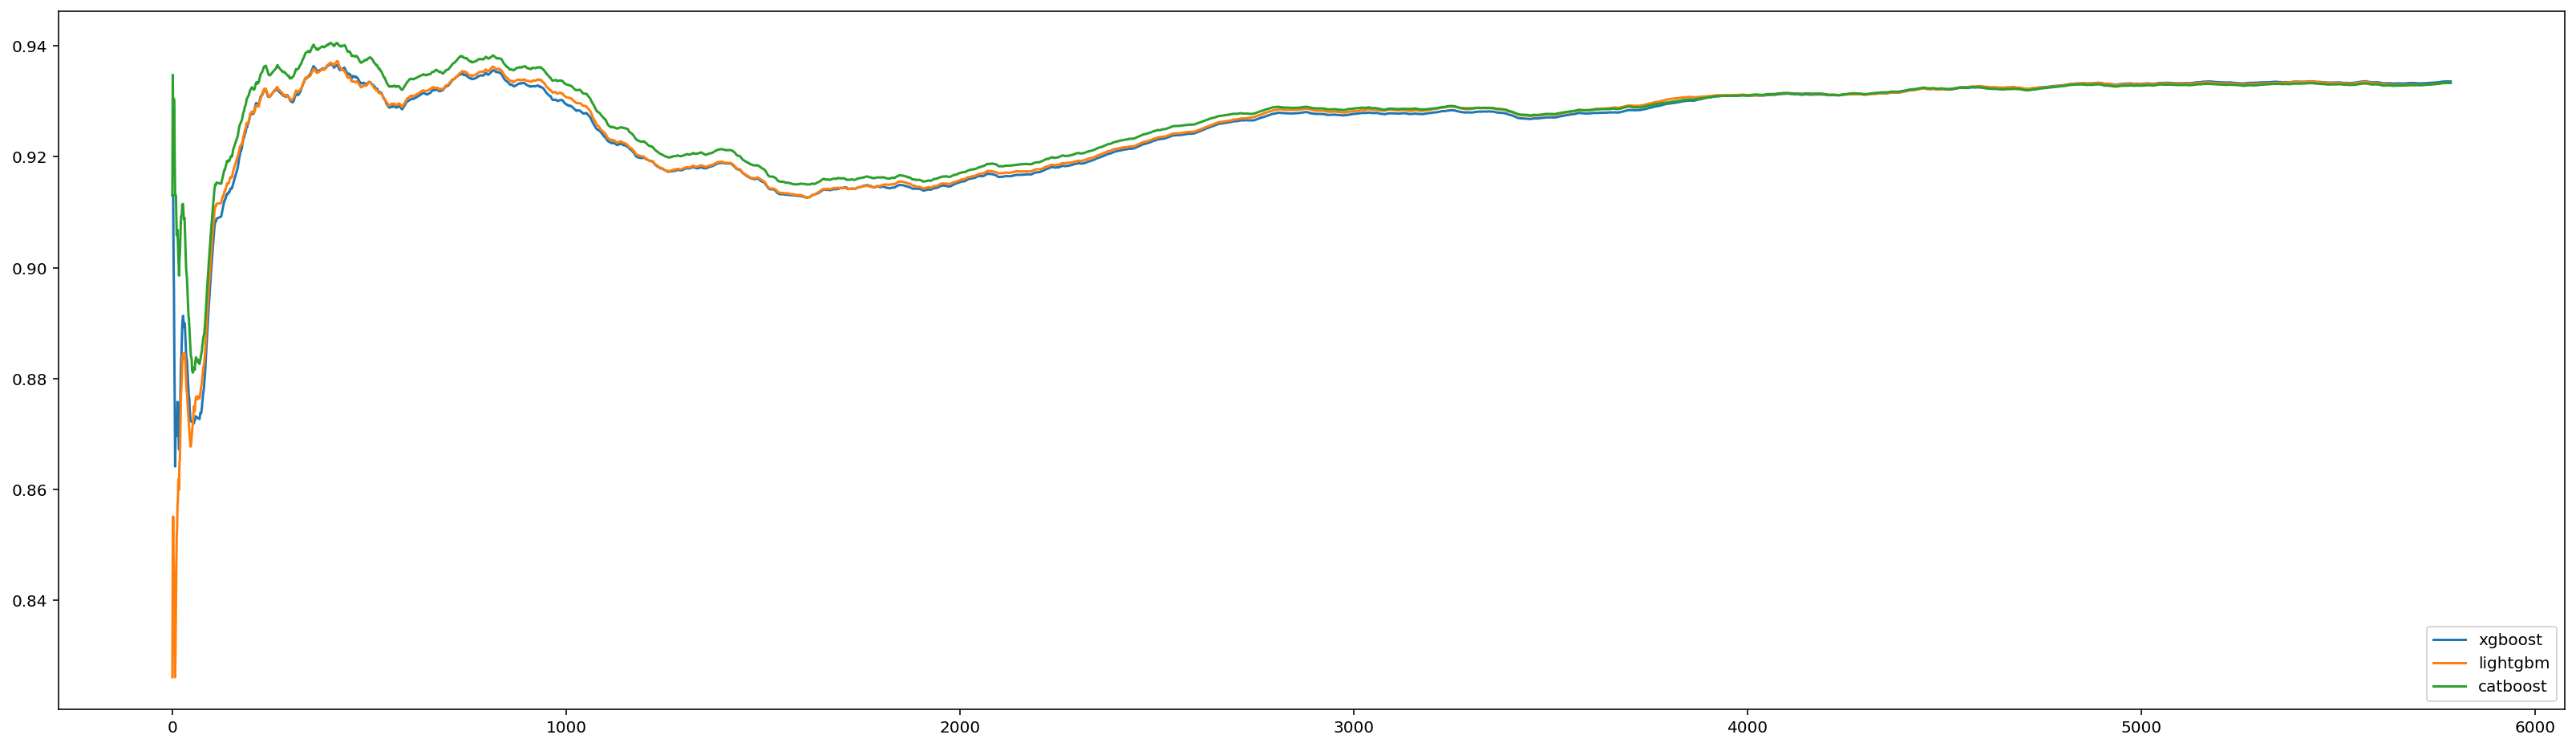

In [98]:
plt.figure(figsize=(28, 8))
for classifier in moving_accuracy:
    minLen = len(moving_accuracy[classifier][0])
    for list in moving_accuracy[classifier]:
        if len(list)<minLen:
            minLen = len(list)

    for list in moving_accuracy[classifier]:
        list = list[:minLen]

    avg_list = [sum(sub_list) / len(sub_list) for sub_list in zip(*moving_accuracy[classifier])]
    plt.plot(avg_list, label = classifier)
    plt.legend()